In [107]:
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.sparse import csr_matrix, hstack

import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

In [6]:
df = pd.read_csv('../mercari/train.tsv', sep='\t')
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [7]:
df.shape

(1482535, 8)

##### Splitting train and test randomly

In [16]:
# msk = int(len(df) * 0.8)
# train = df[:msk]
# test = df[msk:]

msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

In [17]:
print(train.shape, test.shape)

(1186257, 8) (296278, 8)


In [18]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
7,7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1186257 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1186257 non-null int64
name                 1186257 non-null object
item_condition_id    1186257 non-null int64
category_name        1181183 non-null object
brand_name           679932 non-null object
price                1186257 non-null float64
shipping             1186257 non-null int64
item_description     1186255 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 81.5+ MB


In [21]:
train.price.describe()

count    1.186257e+06
mean     2.674692e+01
std      3.843302e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

Text(0.5,1,'Price Distribution')

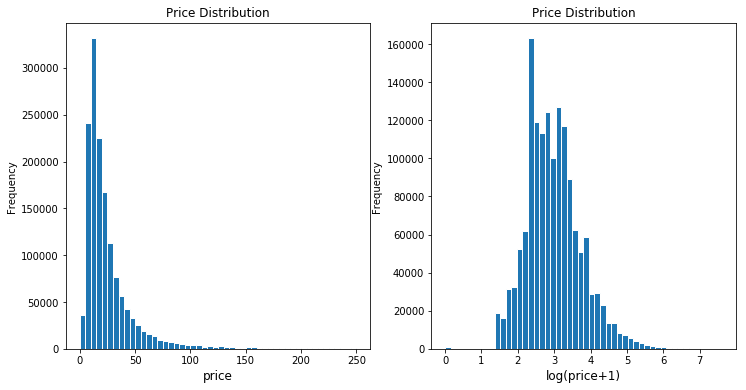

In [28]:
plt.subplot(1,2,1)
df['price'].plot.hist(bins=50, figsize=(12,6), edgecolor='white', range=(0,250))
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)

plt.subplot(1,2,2)
np.log(df['price']+1).plot.hist(bins=50, figsize=(12,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Price Distribution', fontsize=12)

In [29]:
train['shipping'].value_counts()/len(train)

0    0.553053
1    0.446947
Name: shipping, dtype: float64

In [30]:
shipping_fee_by_buyer = train.loc[train['shipping'] == 0, 'price']
shipping_fee_by_seller = train.loc[train['shipping'] == 1, 'price']

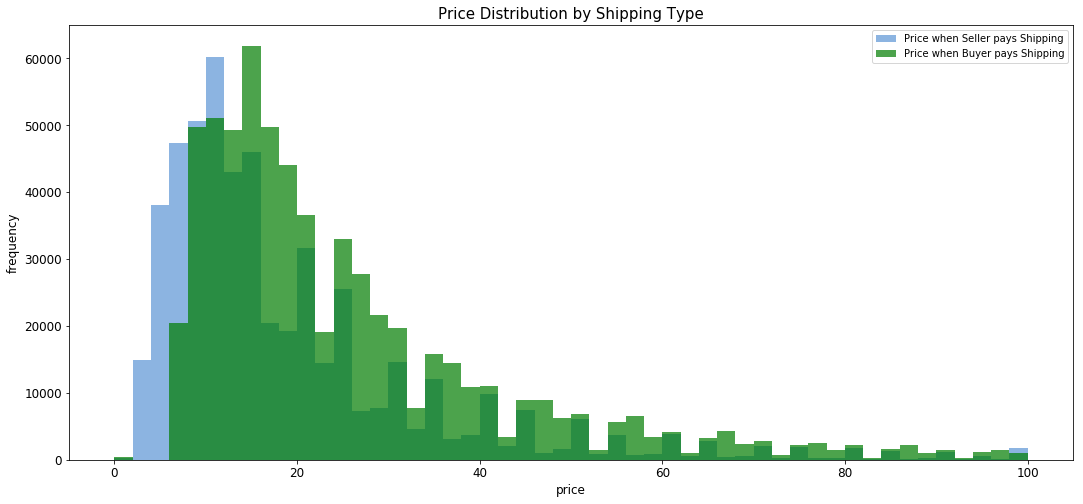

In [38]:
fig, ax = plt.subplots(figsize=(18,8))
ax.hist(x=shipping_fee_by_seller, bins=50, alpha=1.0, color='#8CB4E1', range=[0,100], label='Price when Seller pays Shipping')
ax.hist(x=shipping_fee_by_buyer, bins=50, alpha=0.7, color='#007D00', range=[0,100], label='Price when Buyer pays Shipping')
plt.xlabel('price', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

In [41]:
print(round(shipping_fee_by_buyer.mean(), 2))
print(round(shipping_fee_by_seller.mean(), 2))

30.14
22.55


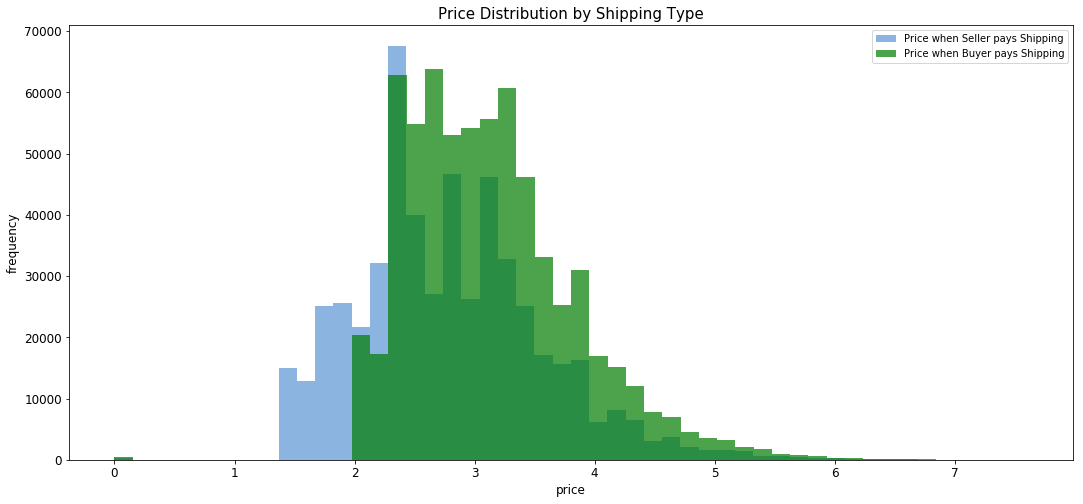

In [45]:
fig, ax = plt.subplots(figsize=(18,8))
ax.hist(x=np.log(shipping_fee_by_seller+1), bins=50, alpha=1.0, color='#8CB4E1', label='Price when Seller pays Shipping')
ax.hist(x=np.log(shipping_fee_by_buyer+1), bins=50, alpha=0.7, color='#007D00', label='Price when Buyer pays Shipping')
plt.xlabel('price', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

In [47]:
train['category_name'].nunique()

1263

In [48]:
train['category_name'].value_counts()[:10]

Women/Athletic Apparel/Pants, Tights, Leggings                 48200
Women/Tops & Blouses/T-Shirts                                  37110
Beauty/Makeup/Face                                             27504
Beauty/Makeup/Lips                                             23826
Electronics/Video Games & Consoles/Games                       21237
Beauty/Makeup/Eyes                                             20090
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    19664
Women/Underwear/Bras                                           16973
Women/Tops & Blouses/Blouse                                    16317
Women/Tops & Blouses/Tank, Cami                                16261
Name: category_name, dtype: int64

In [50]:
train.item_condition_id.value_counts()

1    512978
3    345503
2    300243
4     25619
5      1914
Name: item_condition_id, dtype: int64

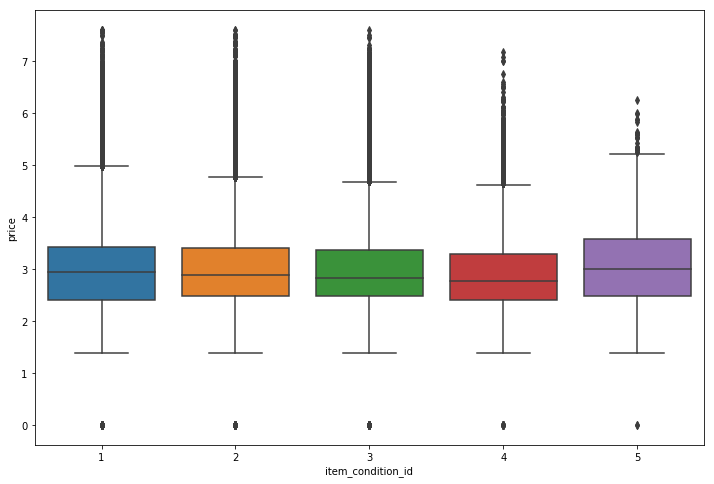

In [53]:
plt.figure(figsize=(12,8))
sns.boxplot(x='item_condition_id', y=np.log(train['price']+1), data=train)

In [54]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
7,7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...


### Light GBM

In [57]:
NUM_BRANDS = 4000
NUM_CATEGORIES = 1000
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 50000

In [59]:
train['category_name'].isnull().sum()

5074

In [60]:
train['brand_name'].isnull().sum()

506325

In [61]:
train.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          5074
brand_name           506325
price                     0
shipping                  0
item_description          2
dtype: int64

In [62]:
train['item_description'].isnull().sum()

2

In [65]:
def handle_missing_inplace(dataset):
    dataset['category_name'].fillna(value='missing', inplace=True)
    dataset['brand_name'].fillna(value='missing', inplace=True)
    dataset['item_description'].replace('No description yet', 'missing', inplace=True)
    dataset['item_description'].fillna(value='missing', inplace=True)

In [66]:
def cutting(dataset):
    pop_brand = dataset['brand_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_BRANDS]
    dataset.loc[~dataset['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'
    pop_category = dataset['catergory_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]

In [90]:
def to_categorical(dataset):
    dataset['category_name'] = dataset['category_name'].astype('category')
    dataset['brand_name'] = dataset['brand_name'].astype('category')
    dataset['item_description'] = dataset['item_description'].astype('category')

In [83]:
df = pd.read_csv('train.tsv', sep = '\t')
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

In [84]:
test_new = test.drop('price', axis=1)
y_test = np.log1p(test['price'])

In [85]:
train = train[train.price !=0].reset_index(drop=True)

In [86]:
nrow_train = train.shape[0]
y = np.log1p(train["price"])

In [98]:
merge: pd.DataFrame = pd.concat([train, test_new])

In [99]:
handle_missing_inplace(merge)
cutting(merge)
to_categorical(merge)

In [100]:
merge.head()

,brand_name,category_name,item_condition_id,item_description,name,price,shipping,train_id
0,missing,Men/Tops/T-shirts,3,missing,MLB Cincinnati Reds T Shirt Size XL,10.0,1,0
1,Razer,Electronics/Computers & Tablets/Components & P...,3,This keyboard is in great condition and works ...,Razer BlackWidow Chroma Keyboard,52.0,0,1
2,Target,Women/Tops & Blouses/Blouse,1,Adorable top with a hint of lace and a key hol...,AVA-VIV Blouse,10.0,1,2
3,missing,Home/Home Décor/Home Décor Accents,1,New with tags. Leather horses. Retail for [rm]...,Leather Horse Statues,35.0,1,3
4,missing,Women/Jewelry/Necklaces,1,Complete with certificate of authenticity,24K GOLD plated rose,44.0,0,4


In [112]:
cv = CountVectorizer(min_df=NAME_MIN_DF)
X_name = cv.fit_transform(merge['name'])

In [108]:
cv = CountVectorizer()
X_category = cv.fit_transform(merge['category_name'])

In [109]:
tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION, ngram_range=(1, 3), stop_words='english')
X_description = tv.fit_transform(merge['item_description'])

In [110]:
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(merge['brand_name'])

In [111]:
X_dummies = csr_matrix(pd.get_dummies(merge[['item_condition_id', 'shipping']], sparse=True).values)

In [113]:
sparse_merge = hstack((X_dummies, X_description, X_brand, X_category, X_name)).tocsr()

In [114]:
sparse_merge.shape

(1481850, 73556)

In [117]:
mask = np.array(np.clip(sparse_merge.getnnz(axis=0) -1, 0, 1), dtype=bool)
sparse_merge = sparse_merge[:, mask]

In [118]:
sparse_merge.shape

(1481850, 72283)

In [120]:
X = sparse_merge[:nrow_train]
X_test = sparse_merge[nrow_train:]

In [121]:
train_X = lgb.Dataset(X, label=y)

In [122]:
params = {
        'learning_rate':0.75,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 100,
        'verbosity': -1,
        'metric': 'RMSE',
}

In [123]:
gbm = lgb.train(params=params, train_set=train_X, num_boost_round=3200, verbose_eval=100)

In [124]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [125]:
from sklearn.metrics import mean_squared_error
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

The rmse of prediction is: 0.4607597431570431


Machine Learning for Retail Price Recommendation with Python     
https://towardsdatascience.com/machine-learning-for-retail-price-suggestion-with-python-64531e64186d